In [1]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import load_model,save_model
from keras.callbacks import ModelCheckpoint
from matplotlib.patches import Rectangle
import os
from scipy.misc import imsave
from tqdm import tqdm

import keras

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.applications import xception
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from keras.optimizers import SGD, Adam,Adagrad
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.advanced_activations import LeakyReLU
from math import sqrt
from keras.callbacks import History 
from keras.optimizers import Adam, SGD
from keras.layers import Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.applications import xception
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, merge
from keras.layers import Activation, Dropout, Flatten, Dense,Input
from keras.layers import BatchNormalization
from keras.models import Model
from keras.activations import relu
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import ELU
import keras.backend as K
from math import sqrt
from keras.callbacks import History 
import gc
from math import log

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dataPath = '/home/rsk/Documents/UPenn/DymaxionLabs/Slum Patches/send_patches'

In [3]:
%run '/home/rsk/Documents/UPenn/DymaxionLabs/Modeling/util.py'


In [4]:
def read_img(filepath, size,grayscale=False):
    
    if grayscale:
        img = image.load_img((filepath), target_size=size,grayscale=True)
        img = image.img_to_array(img,data_format='channels_last')
    else:
        img = image.load_img((filepath), target_size=size)
        img = image.img_to_array(img,data_format='channels_last')
    return img

In [18]:
imgSize = (256,256)
batchSize = 6

In [9]:
fileList = os.listdir(dataPath)
imgList = [x for x in fileList if "img" in x]  #Keeping only the RGB map images
maskList = [x for x in fileList if "mask" in x]  #Keeping only the mask images

In [10]:
X=[]

for i in tqdm(range(500)):
    
    imageName = os.path.join(dataPath,imgList[i])
    maskName = os.path.join(dataPath,imgList[i].replace("img","mask"))
    
    img = image.load_img((imageName), target_size=imgSize)
    img = image.img_to_array(img,data_format='channels_last')
    
    mask = image.load_img((maskName), target_size=imgSize)
    mask = image.img_to_array(mask,data_format='channels_last')
    
    X.append((img,mask))

100%|██████████| 500/500 [00:31<00:00, 15.71it/s]


In [19]:
np.random.shuffle(X)

In [25]:
trainx,trainy,testx,testy = train_test_split(X,ratio = 0.1,imgSize = imgSize)

In [26]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x=trainx,y=trainy,batch_size=batchSize)

test_generator = train_datagen.flow(x=testx,y=testy,batch_size=batchSize)

In [ ]:
np.shape(train_generator.x)

In [ ]:
np.shape(train_generator.y)

In [51]:
a = np.array([1.0,0,0,0,1,0,1,1])
b = np.array([1,0,0,0,1,0,0,0])

In [52]:
getDice(a,b)

0.7142857142857143

In [55]:
c = np.array([1,0.4,0.4,0.4,1.0,0.4,0.4,0.4])

In [56]:
getDice(a,c)

0.8291457286432159

### Model

#### Model 1

In [20]:

inputs = Input((128,128,3))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)


up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(pool4))
merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
# conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
# conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
# conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(input = inputs, output = conv10)

model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy',dice_coef])
# model.compile(optimizer = Adam(lr = 1e-4), loss = dice_coef_loss, metrics = [dice_coef])
    

    

/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:28: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:39: U

#### Model 2

In [27]:

inputs = Input((256,256,3))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)


up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(pool4))
merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
# conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
# conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
# conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(input = inputs, output = conv10)

model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
# model.compile(optimizer = Adam(lr = 1e-4), loss = dice_coef_loss, metrics = [dice_coef])
    

    

/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:28: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:39: U

#### Model run

In [28]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 128, 128, 128 73856       max_pooling2d_5[0][0]            
__________________________________________________________________________________________________
max_poolin

In [29]:
epochs=5

In [31]:
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=1e-5, patience=3, verbose=1)

model.fit_generator(train_generator,epochs=epochs,validation_data=test_generator,callbacks = [lr_reduce],verbose=1)
 

Epoch 1/5
75/75 [==============================] - 63s 835ms/step - loss: 0.2230 - acc: 0.9016 - val_loss: 0.2095 - val_acc: 0.9030
Epoch 2/5
75/75 [==============================] - 63s 834ms/step - loss: 0.1945 - acc: 0.9130 - val_loss: 0.2155 - val_acc: 0.8967
Epoch 3/5
75/75 [==============================] - 62s 824ms/step - loss: 0.1761 - acc: 0.9208 - val_loss: 0.1535 - val_acc: 0.9381
Epoch 4/5
75/75 [==============================] - 64s 852ms/step - loss: 0.1496 - acc: 0.9340 - val_loss: 0.1669 - val_acc: 0.9380
Epoch 5/5
75/75 [==============================] - 62s 821ms/step - loss: 0.1434 - acc: 0.9362 - val_loss: 0.1395 - val_acc: 0.9391


In [94]:
model.evaluate(testx[1:2],testy[1:2])

1/1 [==============================] - 2s 2s/step


[0.180953711271286, 0.988861083984375]

In [95]:
pred = model.predict(testx[1:2])

In [47]:
def evaluateImage(index, testData = True):
    
    pred = model.predict(testx[index:(index+1)])
    scores = model.evaluate(testx[index:(index+1)],testy[index:(index+1)])
    print("Model scores : {}".format(scores))
    print("Predicted entropy : {}".format(getCrossEntropy(mask=testy[index:(index+1)],pred=pred)))
    
    plt.figure(figsize=(20,10))
    plt.subplot(131)
    plt.imshow(pred.reshape(256,256),cmap='gray')
    
    plt.subplot(132)
    plt.imshow(testy[index:(index+1)].reshape(256,256),cmap='gray')
    
    plt.subplot(133)
    plt.imshow(testx[index:(index+1),:,:,1].reshape(256,256))
    
    
    

1/1 [==============================] - 0s 59ms/step
Model scores : [0.6350076794624329, 0.957427978515625]
Predicted entropy : 0.567068537088


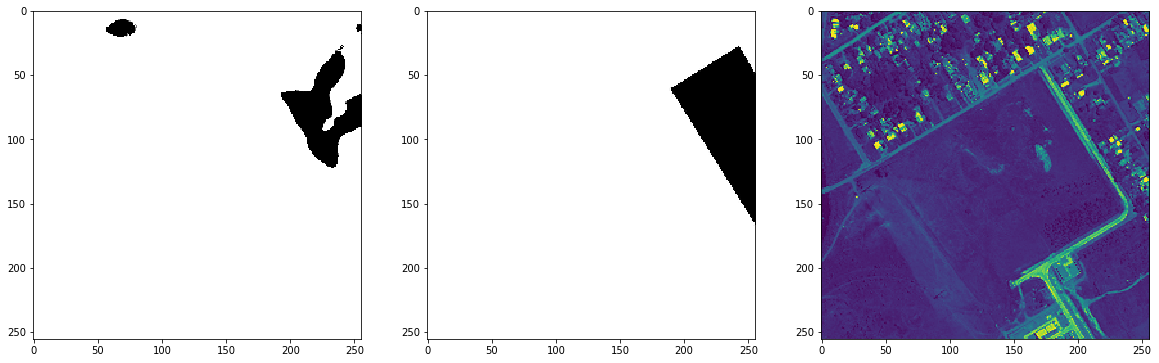

In [50]:
evaluateImage(9)


### Testing

In [41]:
pred = model.predict(trainx[0:6])

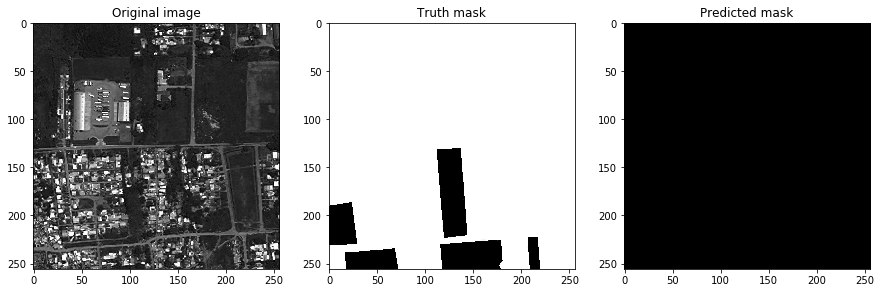

In [43]:
testImage = 5

plt.figure(figsize=(15,30))
plt.subplot(131)
plt.title('Original image')
plt.imshow(trainx[testImage,:,:,0],cmap='gray')


plt.subplot(132)
plt.title('Truth mask')
plt.imshow(trainy[testImage,:,:,0],cmap='gray')

plt.subplot(133)
plt.title('Predicted mask')

plt.imshow(pred[testImage,:,:,0],cmap='gray')

In [165]:
def scorePrint(pred,mask):
    
    acc = accuracy(pred,mask)
    print(acc)
    
    pred = toBinary(pred)
    print(np.min(pred))
    print(np.max(pred))
    plt.subplot(121)
    plt.imshow(pred.reshape(256,256))
    
    print(np.min(mask))
    print(np.max(mask))
    plt.subplot(122)
    plt.imshow(mask.reshape(256,256))
    